Copyright ENEOS Corporation as contributors to Matlantis contrib project.

In [1]:
import os
import sys
import glob
import shutil

from pathlib import Path
from io import StringIO
from time import perf_counter

import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.signal import correlate, convolve, fftconvolve
from scipy.integrate import trapezoid, cumulative_trapezoid
from scipy.fft import fft, fftfreq, fftshift

import ase
from ase import Atoms, units
from ase.io import read, write, Trajectory
from ase.optimize import FIRE, BFGS
from ase.constraints import ExpCellFilter
from ase.phonons import Phonons
from ase.vibrations import Vibrations
from IPython.display import display

In [2]:
from pfcc_extras.visualize.view import view_ngl
from pfcc_extras.structure.ase_rdkit_converter import smiles_to_atoms
from pfp_api_client.pfp.calculators.ase_calculator import ASECalculator
from pfp_api_client.pfp.estimator import Estimator, EstimatorCalcMode

/home/jovyan/.local/lib/python3.7/site-packages/pfp_api_client/__init__.py:36: UserWarning: New version of pfp-api-client is available. Please consider upgrading by `pip install -U pfp-api-client`.
  f"New version of {package_name} is available. Please consider"


In [3]:
MODEL_VERSION='v3.0.0'
CALC_MODE=EstimatorCalcMode.CRYSTAL_PLUS_D3

def get_calculator(model_version=MODEL_VERSION, calc_mode=CALC_MODE):
    estimator = Estimator(model_version=model_version, calc_mode=calc_mode)
    calculator = ASECalculator(estimator)
    return calculator
    

In [4]:

def get_molecule_indices(atoms, fac_distance=1.5):
    huge = 1e8
    d = atoms.get_all_distances(mic=True) + np.eye(len(atoms)) * huge
    nums = atoms.numbers
    x0, x1 = np.meshgrid(nums, nums)
    covalent_distances = covalent_radii[x0] + covalent_radii[x1]
    mask = d < covalent_distances * fac_distance
    g = nx.Graph()
    g.add_edges_from(np.array(np.where(mask)).T)

    indexer = [list(_) for _ in nx.connected_components(g)]
    return indexer


In [5]:
def gauss(x, mu=0.0, sigma=0.5):
    return 1/(np.sqrt(2*np.pi) * sigma) * np.exp(-(x-mu)**2/(2*sigma**2))

### System Settings

In [6]:
# --- System settings
molecule_name = 'DMSO'
nmols = 50
name_smiles = {'DMSO':'CS(=O)C'}
bulk_name = 'Si'

repeat_mol = [3,3,3]
repeat_solid = [3,3,3]

# --- Initial geometry settings
fmax_opt = 0.03
steps_opt = 200
fmax_isolated = 0.01
fmax_liquid = 0.1
mol_cell = [5.0, 5.0, 5.0]

# --- MD settings ----
# Please change based on configuration
target_temp = 300
target_pressure = 101325 * units.Pascal
steps_equilib = 10000
steps_product = 10000
timestep_solid = 2.0
timestep_mol = 1.0
temperature = 300

# --- Parameters
mass_density_factor = units._amu * 1e30 
huge = 999.0
# ------------------

In [7]:
invcm = 1/(units._c * 100)  
eV2kJmol = units.mol/units.kJ 
eV2invcm = 1/(100 * units.J * units._hplanck * units._c)
kT_kJmol = (eV2kJmol * units.kB * target_temp)
beta_kJmol = 1/kT_kJmol
kT = units.kB/units.J * target_temp
beta = 1.0/kT

### Constants and units.

In [8]:
print(f'light speed : {units._c:e} m/s')
print(f'light speed : {units._c*100:e} cm/s')
print(f'1 cm^-1 : {units._c*100:e} Hz')
print(f'eV to cm^-1 : {eV2invcm:.4f}')
print(f'planck const: {units._hplanck} m^2 kg/s')
print(f'T : {target_temp} K')
print('')
print(f'kB : {units.kB:.4e} eV/K')
print(f'kB : {units.kB/units.kJ*units.mol:.4e} kJ/mol K')
print(f'kB : {units.kB/units.J:.4e} J/K')
print('')
print(f'kT : {units.kB*target_temp:.4e} eV')
print(f'kT : {units.kB/units.kJ*units.mol*target_temp:.4e} kJ/mol')
print(f'kT : {units.kB/units.J*target_temp:.4e} J')
#print('')
#print(f'beta : {beta_kJmol:.4e} (kJ/mol)^-1')
#print(f'beta : {beta:.4e} J^-1')

light speed : 2.997925e+08 m/s
light speed : 2.997925e+10 cm/s
1 cm^-1 : 2.997925e+10 Hz
eV to cm^-1 : 8065.5440
planck const: 6.62607004e-34 m^2 kg/s
T : 300 K

kB : 8.6173e-05 eV/K
kB : 8.3145e-03 kJ/mol K
kB : 1.3806e-23 J/K

kT : 2.5852e-02 eV
kT : 2.4943e+00 kJ/mol
kT : 4.1419e-21 J


### Read MD Results

In [9]:
inputdir = './input'
outputdir = './output'
os.makedirs(outputdir, exist_ok=True)

In [10]:
prefix = 'mol'
mol_initial = read(os.path.join(inputdir, f'{prefix}_initial.traj'))

timestep = timestep_mol
prefix_product = f'{prefix}_product{int(timestep*steps_equilib/1000)}ps'
traj_mol = read(f'{outputdir}/{prefix_product}_{temperature}K.traj', index=':')
#traj_mol = read('DMSO_product.traj', index=':')
print(len(traj_mol))

prefix = 'solid'
solid_initial = read(os.path.join(inputdir, f'{prefix}_initial.traj'))

timestep = timestep_solid
prefix_product = f'{prefix}_product{int(timestep*steps_equilib/1000)}ps'
traj_solid = read(f'{outputdir}/{prefix_product}_{temperature}K.traj', index=':')
print(len(traj_solid))

trajs = [traj_solid, traj_mol]
print(traj_solid[0])
print(traj_mol[0])
#print(len(traj_solid), len(traj_mol))

10000
10000
Atoms(symbols='Si216', pbc=True, cell=[[16.277818172140204, 0.013708953081524762, 0.010565936586134058], [0.0, 16.30503468836646, -0.007540314189872502], [0.0, 0.0, 16.302215584470968]], momenta=..., calculator=SinglePointCalculator(...))
Atoms(symbols='C54H162O27S27', pbc=True, cell=[15.40661223024825, 15.40661223024825, 15.40661223024825], momenta=..., calculator=SinglePointCalculator(...))


### Calculate vibrational DOS using static harmonic approximation.

In [11]:
def myopt(atoms, fmax=0.02, cellopt=False):
    atoms.calc = get_calculator()
    if not cellopt:
        opt = BFGS(atoms)
        opt.run(fmax=fmax)
        return atoms

    ecf = ExpCellFilter(atoms)
    opt = BFGS(ecf)
    opt.run(fmax=fmax)
    return atoms

def calc_phononDOS(atoms, supercell=[3,3,3], delta=0.05, kpts=(20, 20, 20), npts=100, width=1e-3, calc=None):
    if calc is None:
        calc = get_calculator()

    ph = Phonons(atoms, calc, supercell=supercell, delta=delta)
    ph.run()

    # Read forces and assemble the dynamical matrix
    ph.read(acoustic=True)
    ph.clean()
    dos_solid = ph.get_dos(kpts=kpts).sample_grid(npts=npts, width=width)
    return dos_solid, ph

def calc_vibDOS(atoms, elim = [0, 0.5], npts=1001, width=0.001, num_ignore_dof=6, calc=None):
    if atoms.calc is None:
        atoms.calc = calc if calc is not None else get_calculator() 
    vib = Vibrations(atoms)
    vib.run()
    eigens = vib.get_energies()
    vib.clean()
    
    eigens = eigens[num_ignore_dof:]
    energies = np.linspace(*elim, npts)
    vdos = np.zeros_like(energies)
    for i, e in enumerate(energies):
        vdos[i] += sum([gauss(_.real, e, width) for _ in eigens])
    return energies, vdos, vib

def calc_vib(atoms, fmax=0.01):
    
    atoms.calc = get_calculator()
    ecf = ExpCellFilter(atoms)
    opt = BFGS(aecf)
    opt.run(fmax=fmax)

    vib = Vibrations(atoms)
    vib.run()
    return vib

In [12]:
atoms = myopt(solid_initial, cellopt=True)
dos_solid, ph = calc_phononDOS(atoms, supercell=repeat_solid)

      Step     Time          Energy         fmax
BFGS:    0 06:16:07      -38.940002        0.0132


23.80485641458214
23.80485641458214
Degree of freedom: 24
Integration of DOS: 23.8049


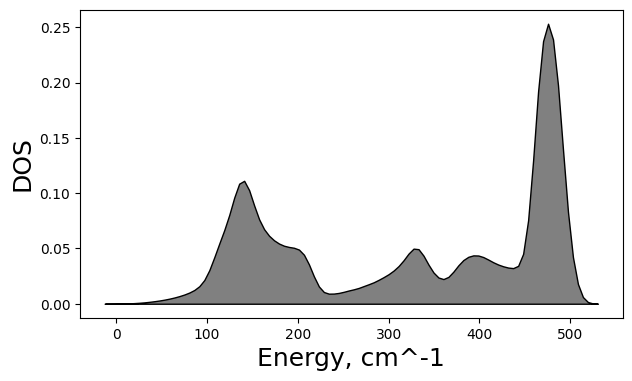

In [13]:
# Plot the band structure and DOS:
fig = plt.figure(1, figsize=(7, 4))
ax = fig.gca()

# energy in eV
energies_solid = dos_solid.get_energies() 
vdos_solid = dos_solid.get_weights() / eV2invcm
de = energies_solid[1] - energies_solid[0]
dof_dos = trapezoid(vdos_solid, dx=de)
print(dof_dos)

# energy in cm-1
energies_solid *= eV2invcm 
vdos_solid /= eV2invcm
de = energies_solid[1] - energies_solid[0]
dof_dos = trapezoid(vdos_solid, dx=de)
print(dof_dos)

ax.fill_between(energies_solid, vdos_solid, y2=0, color='grey',
                   edgecolor='k', lw=1)

ax.set_xlabel("Energy, cm^-1", fontsize=18)
ax.set_ylabel("DOS", fontsize=18)
print(f'Degree of freedom: {3*len(solid_initial)}')
print(f'Integration of DOS: {dof_dos:.4f}')

In [14]:
atoms = myopt(mol_initial, cellopt=False)

#vib.summary()

      Step     Time          Energy         fmax
BFGS:    0 06:16:21      -38.481528        0.0253
BFGS:    1 06:16:21      -38.481562        0.0180


Degree of freedom : 24
Integration of vDOS : 24.0000


Text(0.5, 0, 'Energy, cm^-1')

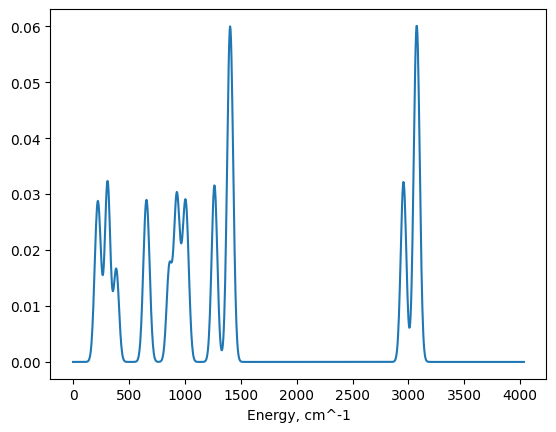

In [15]:
width=0.003
npts=1000
num_dof_rotation = 3
num_dof_translation = 3
num_ignore_dof = num_dof_rotation + num_dof_translation
elim = [0.0, 0.5]

energies_mol, vdos_mol, vib = calc_vibDOS(atoms, elim, npts, width, num_ignore_dof)
energies_mol *= eV2invcm
vdos_mol /= eV2invcm

dof_dos = trapezoid(vdos_mol, energies_mol)
print(f'Degree of freedom : {3*len(atoms)-6}')
print(f'Integration of vDOS : {dof_dos:.4f}')
fig, ax = plt.subplots()
ax.plot(energies_mol, vdos_mol)
ax.set_xlabel('Energy, cm^-1')

In [16]:
## Plot vib DOS using ASE. 
# width=3e-3
# npts=1000

# gridDOS = vibdos.sample_grid(npts, width=width)
# energies_mol = gridDOS.get_energies() * eV2invcm
# vdos_mol = gridDOS.get_weights() / eV2invcm

# fig.show()

# fig, ax = plt.subplots()
# ax.plot(energies_mol, vdos_mol)
# ax.set_xlabel('Energy, cm^-1')
# ax.set_xlim([None, 4000])

## Calculate vibrational DOS using velocity autocorrelation functions.

In [17]:

def calc_vibDOS_fftconvolve(traj,
                            timestep = 2.0,  #solid
                            temperature = None,
                            fs = 1e-15,
                            verbose=False,
                            ):
    
    invcm = 1/(units._c * 100)  
    # eV2kJmol = units.mol/units.kJ 
    # eV2invcm = 1/(100 * units.J * units._hplanck * units._c)


    masses = traj[0].get_masses() * units._amu  # [kg]
    velocities = units.s/units.m * np.array([_.get_velocities() for _ in traj])  # [m/s]
    
    # swap axis for fftconvolve. 
    velocities = velocities.swapaxes(0, 1)
    num_atoms, num_steps, ndim = velocities.shape
    if temperature is None:
        temperature = np.mean([_.get_temperature() for _ in traj])
    
    dt = timestep*fs
    kT = units.kB/units.J * temperature
    beta = 1.0/kT
    
    if verbose:
        print(f'num_atoms: {num_atoms}, num_steps: {num_steps}')
    
    # Calculate velociry autocorrelation function  
    vac = fftconvolve(velocities, velocities[:, ::-1, :], axes=1, mode='full') / num_steps
    mass_vac = masses.reshape(-1, 1, 1) * vac  # mass weighted velocity autocorrelation function
    fft_freq = fftshift(fftfreq(mass_vac.shape[1], d=dt))

    # Calculater vibrational Density of States (vDOS)
    mass_weighted_spectrum_density = 2* beta * fftshift(fft(mass_vac.sum(axis=0).sum(axis=1)) * dt)
    s0 = mass_weighted_spectrum_density[-num_steps]    # spectrum density at freq=0
    df = fft_freq[1]-fft_freq[0]

    energies_invcm = invcm * fft_freq
    vdos = np.abs(mass_weighted_spectrum_density)
    dof_vib = 0.5 * trapezoid(vdos, fft_freq)   # vibrational degree of freedom
    
    if verbose:
        print(f'range of fft_freq : [{np.min(fft_freq):.4e}, {np.max(fft_freq):.4e}]')
        print(f'df : {df:.4e}')

    print(f'degree of freedum : {3*velocities.shape[0]-3}')
    print(f'Integration of vib. DOS : {dof_vib:.2f} (should be equal to dof)')

    

    return energies_invcm, vdos

num_atoms: 216, num_steps: 10000
range of fft_freq : [-2.4999e+14, 2.4999e+14]
df : 2.5001e+10
degree of freedum : 645
Integration of vib. DOS : 644.99 (should be equal to dof)


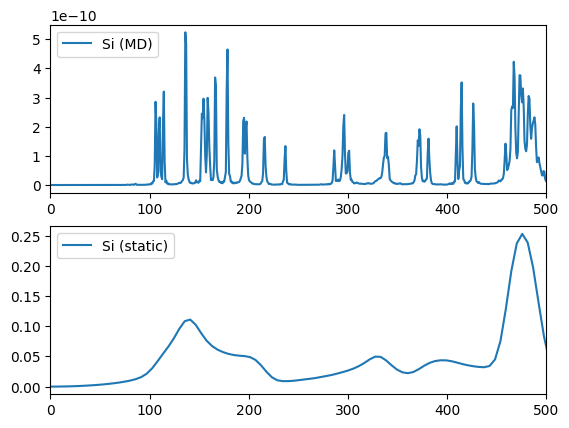

In [18]:
traj = traj_solid
dt = timestep_solid
xlim = [0, 500]

energies, vib_dos = calc_vibDOS_fftconvolve(traj, timestep=dt, temperature=300, verbose=True)

fig, axes = plt.subplots(nrows=2)
ax_MD, ax_static = axes

ax_MD.plot(energies, np.abs(vib_dos), label='Si (MD)')
ax_static.plot(energies_solid, vdos_solid, label='Si (static)')

for ax in axes:
    ax.set_xlim(xlim)
    ax.legend(loc='upper left')

num_atoms: 270, num_steps: 10000
range of fft_freq : [-4.9997e+14, 4.9997e+14]
df : 5.0003e+10
degree of freedum : 807
Integration of vib. DOS : 807.05 (should be equal to dof)


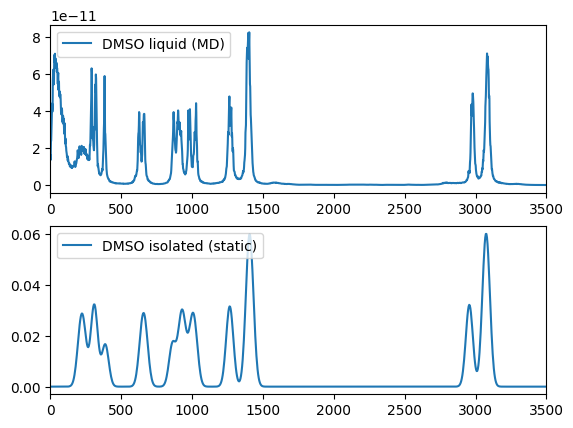

In [19]:
traj = traj_mol
dt = timestep_mol
xlim = [0, 3500]

energies, vib_dos = calc_vibDOS_fftconvolve(traj, timestep=dt, temperature=300, verbose=True)

fig, axes = plt.subplots(nrows=2)
ax_MD, ax_static = axes

ax_MD.plot(energies, np.abs(vib_dos), label='DMSO liquid (MD)')
ax_static.plot(energies_mol, vdos_mol, label='DMSO isolated (static)')

for ax in axes:
    ax.set_xlim(xlim)
    ax.legend(loc='upper left')

In [20]:
del traj_mol, traj_solid
import gc
gc.collect()


8798

In [21]:
removedirs = ['./vib', './phonon']
for _dir in removedirs:
    if os.path.exists(_dir):
        shutil.rmtree(_dir)